In [50]:
### Some initializations
import numpy as np
import math
import random
import copy
from causallearn.search.FCMBased import lingam
import matplotlib.pyplot as plt
import scipy
import scipy.stats
from causallearn.search.ConstraintBased.PC import pc
import warnings
import itertools
import loli
from heapq import nlargest
from matplotlib.patches import Patch
from sklearn.cluster import KMeans

In [51]:
# Via Stack Overflow
# https://stackoverflow.com/questions/11130156/suppress-stdout-stderr-print-from-python-functions
# Supressing the output of annyoing libraries
from contextlib import contextmanager,redirect_stderr,redirect_stdout
from os import devnull

@contextmanager
def suppress_stdout_stderr():
    """A context manager that redirects stdout and stderr to devnull"""
    with open(devnull, 'w') as fnull:
        with redirect_stderr(fnull) as err, redirect_stdout(fnull) as out:
            yield (err, out)

Sample size 1 of 9
Sample size 2 of 9
Sample size 3 of 9
Sample size 4 of 9
Sample size 5 of 9
Sample size 6 of 9
Sample size 7 of 9
Sample size 8 of 9
Sample size 9 of 9


C:\ProgramData\Anaconda3\envs\causal\lib\site-packages\ipykernel_launcher.py:125: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
C:\ProgramData\Anaconda3\envs\causal\lib\site-packages\ipykernel_launcher.py:126: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.


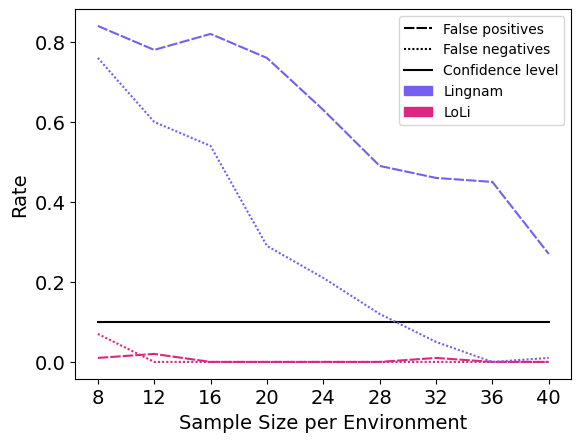

<Figure size 640x480 with 0 Axes>

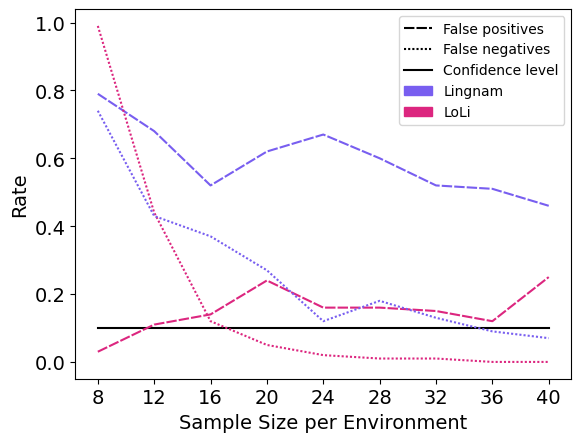

<Figure size 640x480 with 0 Axes>

In [53]:
### Changing sample size
np.random.seed(1)
d=6  #Dimensionality
supp=(1,2) #support indices
s=len(supp)  #Number of support entries
sample=[8,12,16,20,24,28,32,36,40]
fntrunc=np.zeros((len(sample)))
fptrunc=np.zeros((len(sample)))
fnt=np.zeros((len(sample)))
fpt=np.zeros((len(sample)))
fnlingtrunc=np.zeros((len(sample)))
fplingtrunc=np.zeros((len(sample)))
fnlingt=np.zeros((len(sample)))
fplingt=np.zeros((len(sample)))
runs=100
l=1 # Number of intervals we combine for the statistics
B=100 # Bootstrap runs
I=50      #Number of Intervals 
a=[list(itertools.combinations(range(d), k)) for k in range(0,d+1)]
subsets = [item for sublist in a for item in sublist]
dic={}
# We first fix the data for all runs, to eliminate the randomness of this.
betas=np.zeros((runs,I,d))
for r in range(runs):
    for i in range(I):
        betas[r,i,supp]=np.random.uniform(low=1,high=5,size=(s))

for o,n in enumerate(sample):
    print('Sample size',o+1,'of',len(sample))
    for r in range(runs):
        Xt=[]
        Yt=[]
        Xtrunc=[]
        Ytrunc=[]
        X_lingtrunc=[]
        X_lingt=[]
        for i in range(I):
            x=np.zeros((n,d))
            x_lingtrunc=np.zeros((n,d+1))
            x_lingt=np.zeros((n,d+1))
            y=np.zeros((n))
            std=np.random.uniform(low=1,high=5,size=(d))
            x[:,0]=np.random.uniform(low=-6*std[0]**2,high=6*std[0]**2,size=(n))
            x[:,1]=x[:,0]+np.random.uniform(low=-6*std[1]**2,high=6*std[1]**2,size=(n))
            x[:,2]=0.3*x[:,1]+np.random.uniform(low=-6*std[2]**2,high=6*std[2]**2,size=(n))
            x[:,3]=0.2*x[:,2]+np.random.uniform(low=-6*std[3]**2,high=6*std[3]**2,size=(n))
            e=np.random.uniform(low=-6*2**2,high=6*2**2,size=(n))
            y=x@betas[r,i,:]+e
            x[:,4]=np.random.uniform(low=-6*std[4]**2,high=6*std[4]**2,size=(n))+0.1*x[:,1]+0.8*y
            x[:,5]=np.random.uniform(low=-6*std[4]**2,high=6*std[4]**2,size=(n))+0.8*y

            Xtrunc.append(x)
            Ytrunc.append(y)
            x_lingtrunc[:,:d]=copy.copy(x)
            x_lingtrunc[:,d]=copy.copy(y)
            X_lingtrunc.append(x_lingtrunc)
            
            x=np.zeros((n,d))
            y=np.zeros((n))
            std=np.random.uniform(low=1,high=5,size=(d))
            x[:,0]=np.random.standard_t(2*(std[0])**(2)/((std[0])**(2)-1),size=(n))
            x[:,1]=x[:,0]+np.random.standard_t(2*(std[1])**(2)/((std[1])**(2)-1),size=(n))
            x[:,2]=0.3*x[:,1]+np.random.standard_t(2*(std[2])**(2)/((std[2])**(2)-1),size=(n))
            x[:,3]=0.2*x[:,2]+np.random.standard_t(2*(std[3])**(2)/((std[3])**(2)-1),size=(n))
            e=np.random.standard_t(2*(2)**(2)/((2)**(1/2)-1),size=(n))
            y=x@betas[r,i,:]+e
            x[:,4]=np.random.standard_t(2*(std[4])**(2)/((std[4])**(2)-1),size=(n))+0.1*x[:,1]+0.8*y
            x[:,5]=np.random.standard_t(2*(std[5])**(2)/((std[5])**(2)-1),size=(n))+0.8*y

            Xt.append(x)
            Yt.append(y)
            x_lingt[:,:d]=copy.copy(x)
            x_lingt[:,d]=copy.copy(y)
            X_lingt.append(x_lingt)
            
        with suppress_stdout_stderr():
            model=lingam.MultiGroupDirectLiNGAM()
            model.fit(X_lingt)

            
        plausibleS=loli.gauss(Xt,Yt,alpha=0.3)
        if not not plausibleS:
            supphat=set.intersection(*plausibleS)
            if len(supphat.difference(set(supp)))>0:
                fpt[o]+=1/runs
            if len(set(supp).difference(supphat))>0:
                fnt[o]+=1/runs
                
        lingmat=model.adjacency_matrices_[0][6,:]
        lingsupp=np.where(lingmat!=0)
        supphatling=set(lingsupp[0])
        if len(supphatling.difference(set(supp)))>0:
            fplingt[o]+=1/runs
        if len(set(supp).difference(supphatling))>0:
            fnlingt[o]+=1/runs
            
        with suppress_stdout_stderr():
            model=lingam.MultiGroupDirectLiNGAM()
            model.fit(X_lingtrunc)

            
        plausibleS=loli.gauss(Xtrunc,Ytrunc,alpha=0.3)
        if not not plausibleS:
            supphat=set.intersection(*plausibleS)
            if len(supphat.difference(set(supp)))>0:
                fptrunc[o]+=1/runs
            if len(set(supp).difference(supphat))>0:
                fntrunc[o]+=1/runs
                
        lingmat=model.adjacency_matrices_[0][6,:]
        lingsupp=np.where(lingmat!=0)
        supphatling=set(lingsupp[0])
        if len(supphatling.difference(set(supp)))>0:
            fplingtrunc[o]+=1/runs
        if len(set(supp).difference(supphatling))>0:
            fnlingtrunc[o]+=1/runs
            

fig, ax = plt.subplots()
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
	label.set_fontsize(14)
    
false_pos = plt.Line2D([], [], color='black', linestyle=(0, (5, 1)),label='False positives')
false_neg = plt.Line2D([], [], color='black', linestyle=(0, (1, 1)),label='False negatives')
ling = Patch([], [], color='#785EF0',label='Lingnam')
loliplot = Patch([], [], color='#DC267F',label='LoLi')
conf= plt.Line2D([], [], color='black',label='Confidence level')

plt.plot(sample,0.1*np.ones((len(sample))),label='Confidence level',color='black')
plt.plot(sample,fptrunc,'#DC267F',label='False Positive LoLi',linestyle=(0, (5, 1)))
plt.plot(sample,fplingtrunc,'#785EF0',label='False Positive Lingnam',linestyle=(0, (5, 1)))
plt.plot(sample,fntrunc,'#DC267F',label='False Negative LoLi',linestyle=(0, (1, 1)))
plt.plot(sample,fnlingtrunc,'#785EF0',label='False Negative Lingnam',linestyle=(0, (1, 1)))
false_pos = plt.Line2D([], [], color='black', linestyle=(0, (5, 1)),label='False positives')
false_neg = plt.Line2D([], [], color='black', linestyle=(0, (1, 1)),label='False negatives')
ax.legend(handles=[false_pos,false_neg,conf,ling,loliplot])
plt.xticks(sample)
plt.xlabel('Sample Size per Environment',fontsize=14)
plt.ylabel('Rate',fontsize=14)
plt.show()
plt.savefig('Figures/ComparisongLingUniform='+str(I)+'.eps',bbox_inches="tight",format='eps')


fig, ax = plt.subplots()
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
	label.set_fontsize(14)
plt.plot(sample,0.1*np.ones((len(sample))),label='Confidence level',color='black')
plt.plot(sample,fpt,'#DC267F',label='False Positive Truncated',linestyle=(0, (5, 1)))
plt.plot(sample,fplingt,'#785EF0',label='False Positive Student-t',linestyle=(0, (5, 1)))
plt.plot(sample,fnt,'#DC267F',label='False Negative Truncated',linestyle=(0, (1, 1)))
plt.plot(sample,fnlingt,'#785EF0',label='False Negative Student-t',linestyle=(0, (1, 1)))
false_pos = plt.Line2D([], [], color='black', linestyle=(0, (5, 1)),label='False positives')
false_neg = plt.Line2D([], [], color='black', linestyle=(0, (1, 1)),label='False negatives')
ax.legend(handles=[false_pos,false_neg,conf,ling,loliplot])
plt.xticks(sample)
plt.xlabel('Sample Size per Environment',fontsize=14)
plt.ylabel('Rate',fontsize=14)
plt.show()
plt.savefig('Figures/ComparisonLingStudent='+str(I)+'.eps',bbox_inches="tight",format='eps')

C:\ProgramData\Anaconda3\envs\causal\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  import sys
C:\ProgramData\Anaconda3\envs\causal\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  


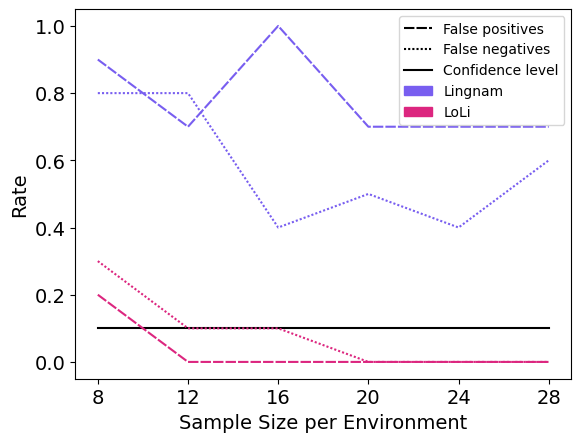

<Figure size 640x480 with 0 Axes>

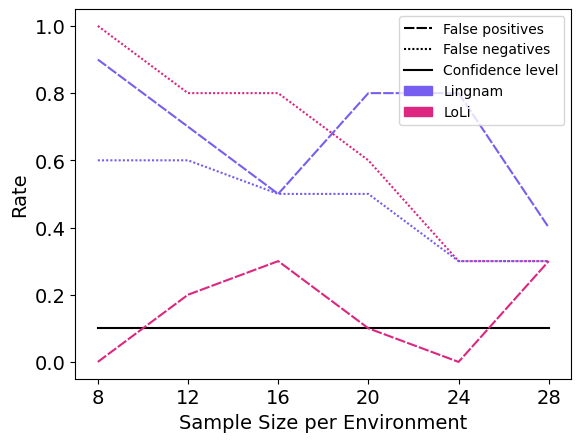

<Figure size 640x480 with 0 Axes>

In [46]:
fig, ax = plt.subplots()
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
	label.set_fontsize(14)
    
false_pos = plt.Line2D([], [], color='black', linestyle=(0, (5, 1)),label='False positives')
false_neg = plt.Line2D([], [], color='black', linestyle=(0, (1, 1)),label='False negatives')
ling = Patch([], [], color='#785EF0',label='Lingnam')
loli = Patch([], [], color='#DC267F',label='LoLi')
conf= plt.Line2D([], [], color='black',label='Confidence level')

plt.plot(sample,0.1*np.ones((len(sample))),label='Confidence level',color='black')
plt.plot(sample,fptrunc,'#DC267F',label='False Positive LoLi',linestyle=(0, (5, 1)))
plt.plot(sample,fplingtrunc,'#785EF0',label='False Positive Lingnam',linestyle=(0, (5, 1)))
plt.plot(sample,fntrunc,'#DC267F',label='False Negative LoLi',linestyle=(0, (1, 1)))
plt.plot(sample,fnlingtrunc,'#785EF0',label='False Negative Lingnam',linestyle=(0, (1, 1)))
false_pos = plt.Line2D([], [], color='black', linestyle=(0, (5, 1)),label='False positives')
false_neg = plt.Line2D([], [], color='black', linestyle=(0, (1, 1)),label='False negatives')
ax.legend(handles=[false_pos,false_neg,conf,ling,loli])
plt.xticks(sample)
plt.xlabel('Sample Size per Environment',fontsize=14)
plt.ylabel('Rate',fontsize=14)
plt.show()
plt.savefig('Figures/ComparisongLingUniform='+str(I)+'.eps',bbox_inches="tight",format='eps')


fig, ax = plt.subplots()
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
	label.set_fontsize(14)
plt.plot(sample,0.1*np.ones((len(sample))),label='Confidence level',color='black')
plt.plot(sample,fpt,'#DC267F',label='False Positive Truncated',linestyle=(0, (5, 1)))
plt.plot(sample,fplingt,'#785EF0',label='False Positive Student-t',linestyle=(0, (5, 1)))
plt.plot(sample,fnt,'#DC267F',label='False Negative Truncated',linestyle=(0, (1, 1)))
plt.plot(sample,fnlingt,'#785EF0',label='False Negative Student-t',linestyle=(0, (1, 1)))
false_pos = plt.Line2D([], [], color='black', linestyle=(0, (5, 1)),label='False positives')
false_neg = plt.Line2D([], [], color='black', linestyle=(0, (1, 1)),label='False negatives')
ax.legend(handles=[false_pos,false_neg,conf,ling,loli])
plt.xticks(sample)
plt.xlabel('Sample Size per Environment',fontsize=14)
plt.ylabel('Rate',fontsize=14)
plt.show()
plt.savefig('Figures/ComparisonLingStudent='+str(I)+'.eps',bbox_inches="tight",format='eps')

Sample size 1 of 2
Sample size 2 of 2


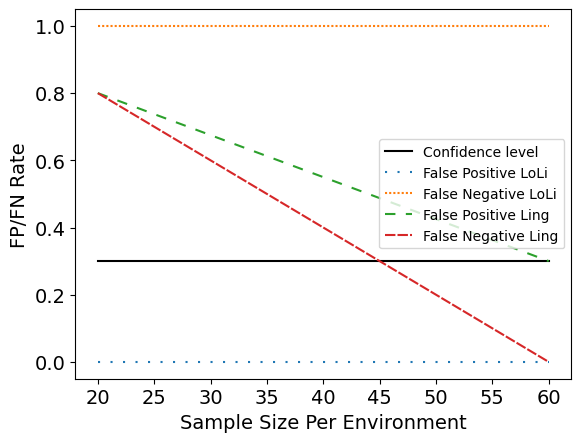

In [36]:
### Changing sample size
np.random.seed(1)
d=6  #Dimensionality
supp=(0,1,2,3) #support indices
s=len(supp)  #Number of support entries
# sample=[14,18,22,26,30,34]
sample=[20,60]
fn=np.zeros((len(sample)))
fp=np.zeros((len(sample)))
fnling=np.zeros((len(sample)))
fpling=np.zeros((len(sample)))
runs=10
l=1 # Number of intervals we combine for the statistics
B=100 # Bootstrap runs
I=10      #Number of Intervals 
a=[list(itertools.combinations(range(d), k)) for k in range(0,d+1)]
subsets = [item for sublist in a for item in sublist]
dic={}
# We first fix the data for all runs, to eliminate the randomness of this.
betas=np.zeros((runs,I,d))
for r in range(runs):
    for i in range(I):
        betas[r,i,supp]=np.random.uniform(low=-5,high=5,size=(s))

for o,n in enumerate(sample):
    print('Sample size',o+1,'of',len(sample))
    for r in range(runs):
        X=[]
        X_ling=[]
        Y=[]
        for i in range(I):
            x_ling=np.zeros((n,d+1))
            x=np.zeros((n,d))
            y=np.zeros((n))
            std=np.random.uniform(low=5,high=5,size=(d))
            p=np.random.uniform(low=0.4,high=1)
            x[:,0]=np.random.uniform(low=-std[0],high=std[0],size=(n))
            x[:,1]=x[:,0]+np.random.uniform(low=-std[1],high=std[1],size=(n))
            x[:,2]=0.3*x[:,1]+np.random.uniform(low=-std[2],high=std[2],size=(n))
            x[:,3]=0.2*x[:,2]+np.random.uniform(low=-std[3],high=std[3],size=(n))
            e=np.random.uniform(low=-2,high=2,size=(n))
            y=x@betas[r,i,:]+e
            std=np.random.uniform(low=-5,high=5,size=(d))
            x[:,4]=np.random.uniform(low=-1,high=10,size=(n))+y
            x[:,5]=np.random.uniform(low=-1,high=1,size=(n))
            x_ling[:,:d]=copy.copy(x)
            x_ling[:,d]=copy.copy(y)
            X.append(x)
            Y.append(y)
            X_ling.append(x_ling)
        plausibleS=loli.gauss(X,Y)
        if not not plausibleS:
            supphat=set.intersection(*plausibleS)
        with suppress_stdout_stderr():
            model=lingam.MultiGroupDirectLiNGAM()
            model.fit(X_ling)

            
        plausibleS=loli.gauss(X,Y,alpha=0.3)
        if not not plausibleS:
            supphat=set.intersection(*plausibleS)
            if len(supphat.difference(set(supp)))>0:
                fp[o]+=1/runs
            if len(set(supp).difference(supphat))>0:
                fn[o]+=1/runs
                
        lingmat=model.adjacency_matrices_[0][6,:]
        lingsupp=np.where(lingmat!=0)
        supphatling=set(lingsupp[0])
        if len(supphatling.difference(set(supp)))>0:
            fpling[o]+=1/runs
        if len(set(supp).difference(supphatling))>0:
            fnling[o]+=1/runs
                


fig, ax = plt.subplots()
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
	label.set_fontsize(14)
plt.plot(sample,0.3*np.ones((len(sample))),label='Confidence level',color='black')
plt.plot(sample,fp,label='False Positive LoLi',linestyle=(0, (1, 5)))
plt.plot(sample,fn,label='False Negative LoLi',linestyle=(0, (1, 1)))
plt.plot(sample,fpling,label='False Positive Ling',linestyle=(0, (5, 5)))
plt.plot(sample,fnling,label='False Negative Ling',linestyle=(0, (5, 1)))

plt.xlabel('Sample Size Per Environment',fontsize=14)
plt.ylabel('FP/FN Rate',fontsize=14)
plt.legend()
# plt.savefig('Figures/CompLingamchangesample.eps',bbox_inches="tight",format='eps')





In [37]:
y

array([ -8.17379917,  10.45448704,   7.11997842, -11.03242595,
         6.98839996, -14.2959893 ,  20.27254312,  -7.59539407,
         7.52030243,  16.41828323,  -5.03754209, -10.06479083,
        -3.54172935,   9.2777957 ,   6.72528383, -11.64955647,
        -6.59685315,   2.76858284,   7.823005  ,  -1.64206186,
        -0.49804794,  -9.69085639,   8.2154978 ,  -4.96199888,
        14.30327806,  -5.77519491,   6.43074744,  -5.69330973,
        -0.5957506 , -11.72978397, -10.9626536 ,   2.81837107,
         7.55187112,   5.97345906,   8.75288645, -13.03991493,
        -7.28321501,  11.56776342,  19.77200577,  -5.01591417,
        -3.97009295,  -1.37148853,   5.75096768,   1.45859694,
       -21.39407099, -10.74818401, -15.08116342,  -4.82101153,
         2.28768893,   5.20861579,   2.18617662,  -5.40751945,
        -3.2672145 ,  -1.42762362,   7.80290466, -12.22453554,
         4.70328983,   8.59716366,   6.06573658,  -5.99987449])

In [254]:
### Changing sample size
np.random.seed(1)
d=6  #Dimensionality
supp=(1,2) #support indices
s=len(supp)  #Number of support entries
sample=[8,10,12,14,16,18,20]
fn=np.zeros((len(sample)))
fp=np.zeros((len(sample)))
fnpc=np.zeros((len(sample)))
fp=np.zeros((len(sample)))
runs=100
l=1 # Number of intervals we combine for the statistics
B=100 # Bootstrap runs
I=50      #Number of Intervals 
a=[list(itertools.combinations(range(d), k)) for k in range(0,d+1)]
subsets = [item for sublist in a for item in sublist]
dic={}
# We first fix the data for all runs, to eliminate the randomness of this.
betas=np.zeros((runs,I,d))
for r in range(runs):
    for i in range(I):
        betas[r,i,supp]=np.random.uniform(low=1,high=5,size=(s))

for o,n in enumerate(sample):
    print('Sample size',o+1,'of',len(sample))
    for r in range(runs):
        X=[]
        Y=[]
        for i in range(I):
            x=np.zeros((n,d))
            y=np.zeros((n))
            std=np.random.uniform(low=1,high=5,size=(d))
            x[:,0]=np.random.normal(scale=std[0],size=(n))
            x[:,1]=x[:,0]+np.random.normal(scale=std[1],size=(n))
            x[:,2]=0.3*x[:,1]+np.random.normal(scale=std[2],size=(n))
            x[:,3]=0.2*x[:,2]+np.random.normal(scale=std[3],size=(n))
            e=np.random.multivariate_normal(0*np.ones(n),1*np.eye(n))
            y=x@betas[r,i,:]+e
            x[:,4]=np.random.normal(scale=std[4],size=(n))+0.1*x[:,1]+y
            x[:,5]=np.random.normal(scale=std[5],size=(n))+y
            x_pc[i*n:(i+1)*n,:6]=copy.copy(x)
            x_pc[i*n:(i+1)*n,:6]=copy.copy(y)
            X.append(x)
            Y.append(y)

            
        plausibleS=loli.gauss(X,Y)
        if not not plausibleS:
            supphat=set.intersection(*plausibleS)
            if len(supphat.difference(set(supp)))>0:
                fp[o]+=1/runs
            if len(set(supp).difference(supphat))>0:
                fn[o]+=1/runs
                
        cg = pc(x_pc,alpha=0.1)
                


fig, ax = plt.subplots()
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
	label.set_fontsize(14)
plt.plot(sample,0.1*np.ones((len(sample))),label='Confidence level',color='black')
plt.plot(sample,fp,label='False Positive SEM',linestyle=(0, (1, 5)))
plt.plot(sample,fn,label='False Negative SEM',linestyle=(0, (1, 1)))
plt.plot(sample,fpind,label='False Positive GAUSS',linestyle=(0, (5, 5)))
plt.plot(sample,fnind,label='False Negative GAUSS',linestyle=(0, (5, 1)))

plt.xlabel('Sample Size Per Environment',fontsize=14)
plt.ylabel('FP/FN Rate',fontsize=14)
plt.legend()
# plt.savefig('Figures/Samplechangen.eps',bbox_inches="tight",format='eps')





  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Graph Nodes:
X1;X2;X3

Graph Edges:
1. X1 o-o X2
2. X2 o-o X3

[[ 0 -1  0]
 [-1  0 -1]
 [ 0 -1  0]]


In [263]:
import numpy as np
from causallearn.search.FCMBased import lingam
supp=(1,2)
s=len(supp)
d=7
n=500 # Sample size
I=1      #Number of Intervals 
# We first fix the data for all runs, to eliminate the randomness of this.
betas=np.zeros((I,d))



x=np.zeros((I*n,d))
for i in range(I):
    betas[i,supp]=np.random.uniform(low=1,high=1,size=(s))
    std=np.random.uniform(low=1,high=1,size=(d))
    x[i*n:(i+1)*n,0]=np.random.uniform(low=-std[0],high=std[0],size=(n))
    x[i*n:(i+1)*n,1]=x[i*n:(i+1)*n,0]+np.random.uniform(low=-std[1],high=std[1],size=(n))
#     x[i*n:(i+1)*n,0]=np.random.normal(scale=10*std[0],size=(n))
#     x[i*n:(i+1)*n,1]=x[i*n:(i+1)*n,0]+np.random.normal(scale=std[1],size=(n))
    x[i*n:(i+1)*n,2]=0.3*x[i*n:(i+1)*n,1]+np.random.uniform(low=-std[1],high=std[1],size=(n))
    x[i*n:(i+1)*n,3]=0.2*x[i*n:(i+1)*n,2]+np.random.uniform(low=-std[1],high=std[1],size=(n))
    e=np.random.uniform(low=-std[1],high=std[1],size=(n))
#     e=np.random.uniform(low=-1,high=1,size=(n))
    x[i*n:(i+1)*n,6]=x[i*n:(i+1)*n,:]@betas[i,:]+e
    x[i*n:(i+1)*n,5]=np.random.uniform(low=-std[1],high=std[1],size=(n))
    x[i*n:(i+1)*n,4]=np.random.uniform(low=-std[1],high=std[1],size=(n))+0.1*x[i*n:(i+1)*n,1]+x[i*n:(i+1)*n,6]+x[i*n:(i+1)*n,5]
data=x
# default parameters
cg = pc(data,alpha=0.1)
G, edges = fci(data)

# print(G)
# print(cg.G.graph)

model = lingam.ICALiNGAM()
model.fit(data)
# print(model.causal_order_)
print(np.round(model.adjacency_matrix_))


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

X7 --> X5
[[0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0.]]


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight